In [65]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf
from object_detection.protos.string_int_label_map_pb2 import StringIntLabelMap, StringIntLabelMapItem
from google.protobuf import text_format
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [5]:
dataset_name = "plane-dataset" # The name of the V51 dataset that will be used
training_name = "simple_model"

In [6]:
# The different directories and filenames to use
train_record_fname = "/tf/dataset-export/" + training_name + "/train/tf.records"
val_record_fname = "/tf/dataset-export/" + training_name + "/val/tf.records"

In [10]:
raw_image_dataset = tf.data.TFRecordDataset(train_record_fname)
image_feature_description = {
    # Image dimensions
    "image/height": tf.io.FixedLenFeature([], tf.int64),
    "image/width": tf.io.FixedLenFeature([], tf.int64),

    # Image filename is used for both of these when writing
    "image/filename": tf.io.FixedLenFeature([], tf.string),
    "image/source_id": tf.io.FixedLenFeature([], tf.string),

    # Encoded image bytes
    "image/encoded": tf.io.FixedLenFeature([], tf.string),

    # Image format, either `jpeg` or `png`
    "image/format": tf.io.FixedLenFeature([], tf.string),

    # Normalized bounding box coordinates in `[0, 1]`
    "image/object/bbox/xmin": tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    "image/object/bbox/xmax": tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    "image/object/bbox/ymin": tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    "image/object/bbox/ymax": tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),

    # Class label string
    "image/object/class/text": tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True),

    # Integer class ID
    "image/object/class/label": tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True)
}
def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)



In [11]:
parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {image/encoded: (), image/filename: (), image/format: (), image/height: (), image/object/bbox/xmax: (None,), image/object/bbox/xmin: (None,), image/object/bbox/ymax: (None,), image/object/bbox/ymin: (None,), image/object/class/label: (None,), image/object/class/text: (None,), image/source_id: (), image/width: ()}, types: {image/encoded: tf.string, image/filename: tf.string, image/format: tf.string, image/height: tf.int64, image/object/bbox/xmax: tf.float32, image/object/bbox/xmin: tf.float32, image/object/bbox/ymax: tf.float32, image/object/bbox/ymin: tf.float32, image/object/class/label: tf.int64, image/object/class/text: tf.string, image/source_id: tf.string, image/width: tf.int64}>

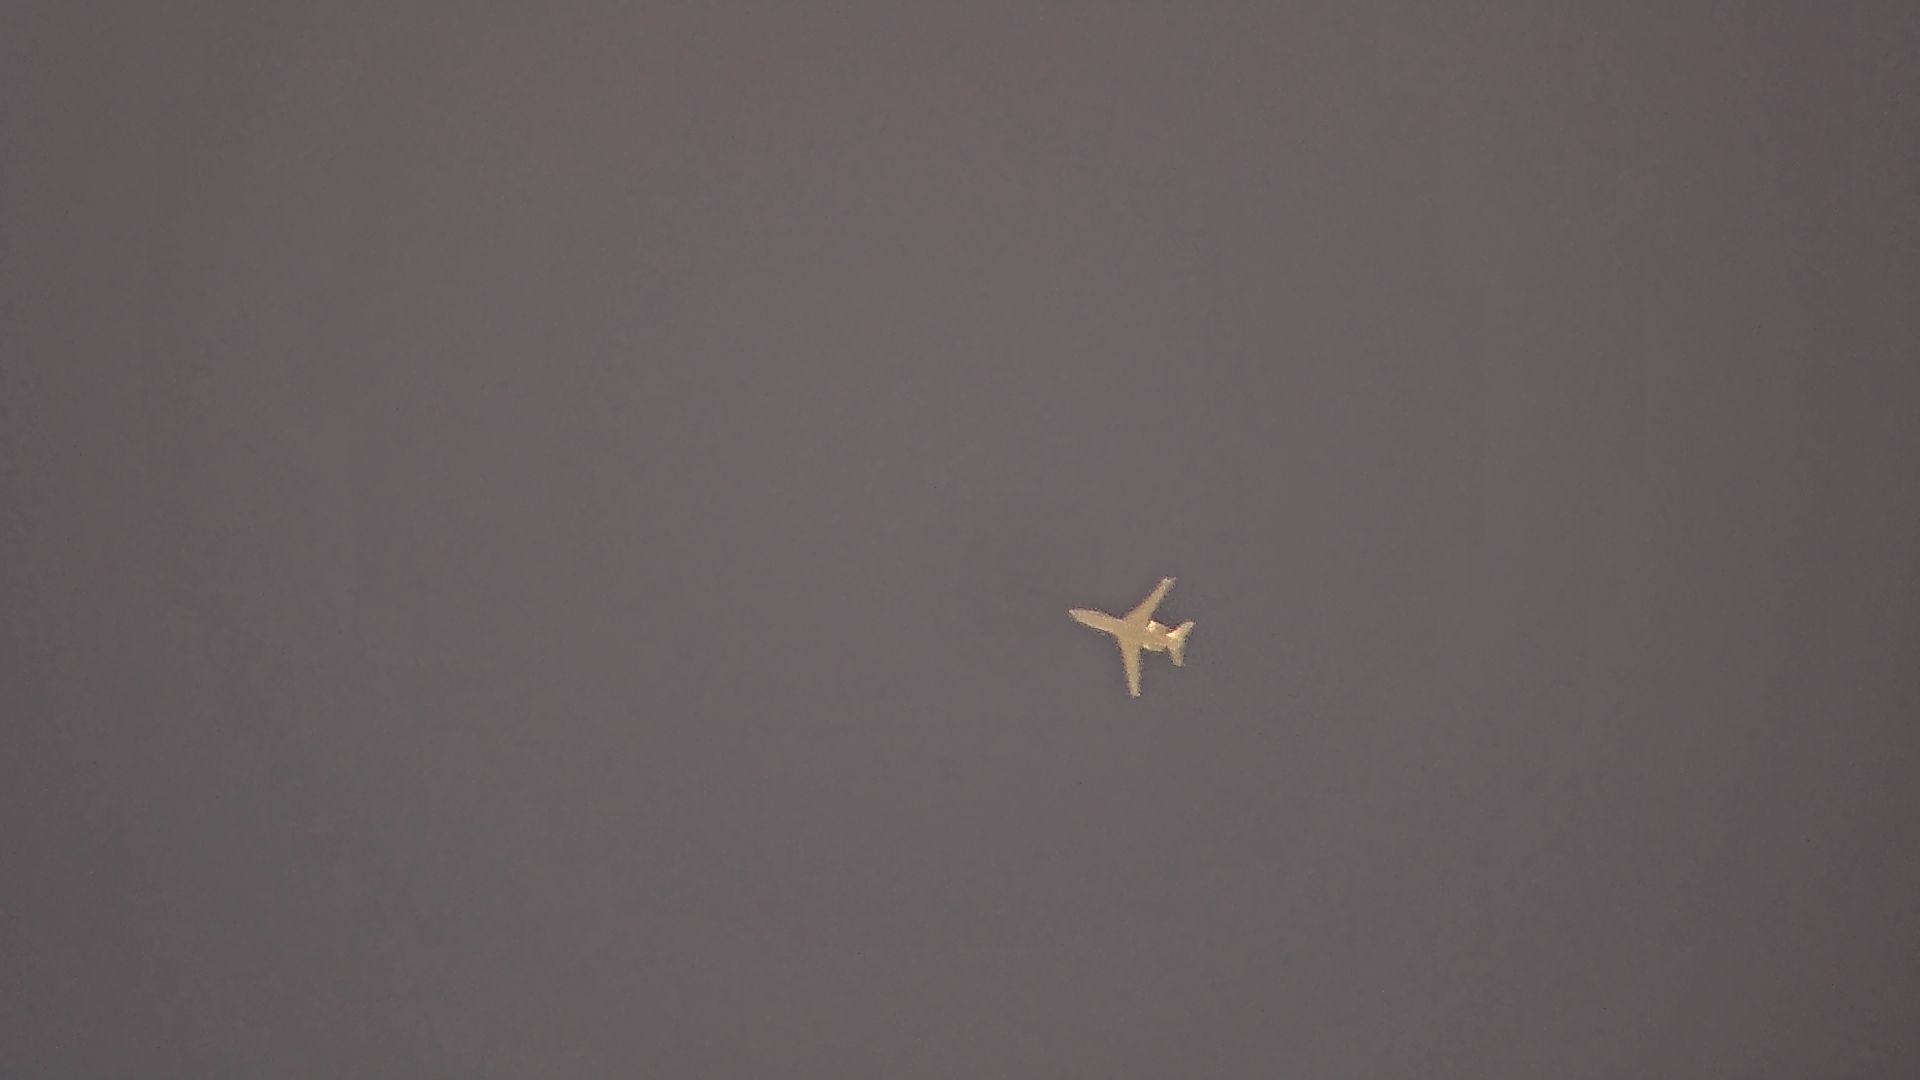

In [40]:
for image_features in parsed_image_dataset.take(1):
  image_raw = image_features['image/encoded'].numpy()
  display(IPyImage(data=image_raw))

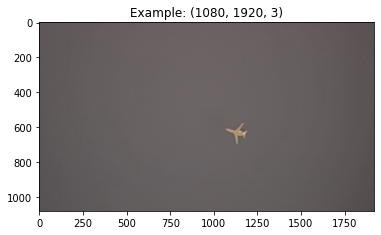

In [210]:
for image_features in parsed_image_dataset.take(1):
    image_raw = image_features['image/encoded'].numpy()
    img = tf.io.decode_image(image_raw)
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.image.resize(img, [500,500])

    plt.figure()

    plt.title("Example: {}".format(img.shape))
    
    _ = plt.imshow(img)
    #display(IPyImage(data=image_raw))

In [69]:
from object_detection.utils import test_case
from object_detection.utils import test_utils
from object_detection.core import standard_fields as fields
from object_detection import inputs
from object_detection.core import preprocessor
import functools

In [213]:

class DataAugmentationFnTest(test_case.TestCase):
    def createTestLabels(self):
        labels = tf.constant([1, 2], dtype=tf.int32)
        return labels

    def createTestLabelsLong(self):
        labels = tf.constant([1, 2, 4], dtype=tf.int32)
        return labels



    def createTestBoxes(self):
        boxes = tf.constant(
            [[0.0, 0.1, 0.1, 0.2], [0.25, 0.5, 0.5, 0.75]], dtype=tf.float32)
        return boxes
    def createTestGroundtruthWeights(self):
        return tf.constant([1.0, 0.5], dtype=tf.float32)

    def test_apply_image_and_box_augmentation(self, input_image):
        data_augmentation_options = [
            (preprocessor.random_distort_color, {}),
            (preprocessor.random_horizontal_flip, {}),
            (preprocessor.random_vertical_flip, {}),
            (preprocessor.random_rotation90, {}),
            (preprocessor.random_crop_image, {
                "min_object_covered": 1.0,
                "aspect_ratio_range": (0.75,1.5),
                "area_range": (0.25, 0.875),
                "overlap_thresh": 0.5,
                "random_coef": 0.5
            }),
            (preprocessor.scale_boxes_to_pixel_coordinates, {}),
        ]
        data_augmentation_fn = functools.partial(
            inputs.augment_input_data,
            data_augmentation_options=data_augmentation_options)
        

        def graph_fn():
          boxes = self.createTestBoxes()
          labels = self.createTestLabels()
          weights = self.createTestGroundtruthWeights()

          tensor_dict = {
              fields.InputDataFields.image:
                  tf.constant(input_image),
              fields.InputDataFields.groundtruth_boxes: boxes,
              fields.InputDataFields.groundtruth_classes: labels,
              fields.InputDataFields.groundtruth_weights: weights
          }
          augmented_tensor_dict = data_augmentation_fn(tensor_dict=tensor_dict)
          return (augmented_tensor_dict[fields.InputDataFields.image],
                  augmented_tensor_dict[fields.InputDataFields.groundtruth_boxes],
                  augmented_tensor_dict[fields.InputDataFields.groundtruth_classes],
                  augmented_tensor_dict[fields.InputDataFields.groundtruth_weights])
        
        image, groundtruth_boxes, classes, weights = self.execute_cpu(graph_fn, [])

        return image



In [214]:
tester = DataAugmentationFnTest()

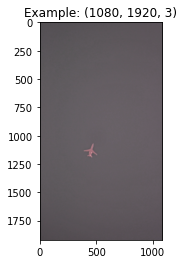

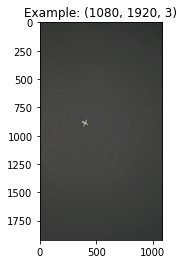

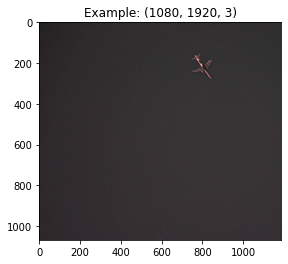

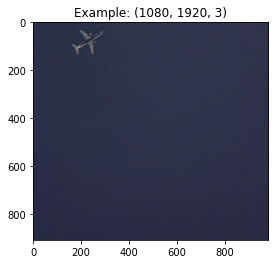

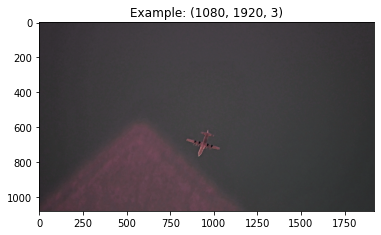

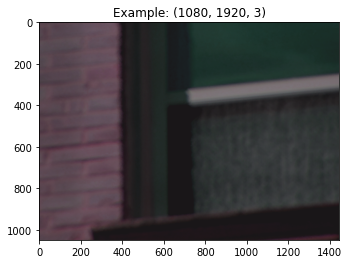

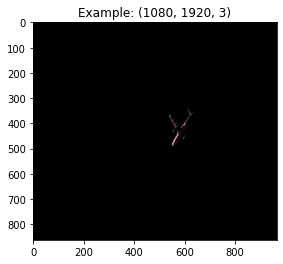

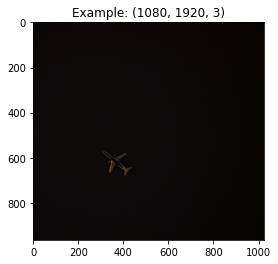

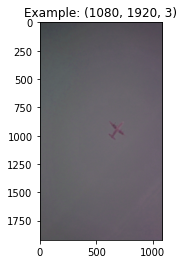

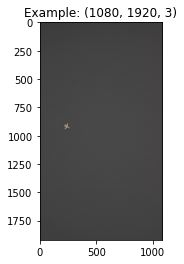

In [215]:
for image_features in parsed_image_dataset.take(10):
    image_raw = image_features['image/encoded'].numpy()
    img = tf.io.decode_image(image_raw) # the image is in uint8
    result = tester.test_apply_image_and_box_augmentation(img)
    float_result = tf.image.convert_image_dtype(result/255, tf.float32)
    plt.figure()

    plt.title("Example: {}".format(img.shape))
    _ = plt.imshow(float_result)
